In [1]:
# Basic
import os
import numpy as np
import pandas as pd

# My Packages
import nets as nets

# MatPlotLib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#PIL
from PIL import Image

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms


# Captum
from captum.attr import IntegratedGradients, DeepLift, GradientShap, Occlusion
from captum.attr import visualization as viz

In [2]:
report_base_path = "./plots/all_fixed"

# Fixed Backbone

In [3]:
df_train = pd.read_csv("./all_fixed/all_fixed_reports/efficientnet_b0_2022_4_8_6_37_53.csv")
df_train.drop(columns=["Unnamed: 0"], inplace=True)

df_val = df_train[ df_train["train/eval"]=="val"]
df_train = df_train[ df_train["train/eval"]=="train"]

df_train.head(5)

,epoch,train/eval,batch_size,loss,acc,correct,lr
0,0,train,32,5.280322,NaN,1,0.001
1,0,train,32,5.356028,NaN,1,0.001
2,0,train,32,5.263180,NaN,0,0.001
3,0,train,32,5.221047,NaN,2,0.001
4,0,train,32,5.302030,NaN,0,0.001


In [4]:
df_val.head(5)

,epoch,train/eval,batch_size,loss,acc,correct,lr
204,0,val,32,134.369308,NaN,5,NaN
205,0,val,32,129.511063,NaN,5,NaN
206,0,val,32,135.564117,NaN,4,NaN
207,0,val,32,141.072189,NaN,4,NaN
208,0,val,32,135.775269,NaN,4,NaN


## Training & Validation 

In [5]:
df_train_epoch = df_train[["epoch", "loss", "batch_size", "correct"]].groupby(by="epoch").sum()
df_train_epoch["loss_mean"] = df_train_epoch["loss"] / df_train_epoch["batch_size"]
df_train_epoch["accuracy"] = df_train_epoch["correct"] / df_train_epoch["batch_size"]

df_train_epoch.head(5)

,loss,batch_size,correct,loss_mean,accuracy
epoch,,,,,
0,949.720659,6501,592,0.146088,0.091063
1,789.302896,6501,1419,0.121413,0.218274
2,727.183392,6501,1906,0.111857,0.293186
3,683.030908,6501,2237,0.105066,0.344101
4,657.153658,6501,2402,0.101085,0.369482


In [6]:
df_val_epoch = df_val[["epoch", "loss", "batch_size", "correct"]].groupby(by="epoch").sum()
df_val_epoch["loss_mean"] = df_val_epoch["loss"] / df_val_epoch["batch_size"]
df_val_epoch["accuracy"] = df_val_epoch["correct"] / df_val_epoch["batch_size"]

df_val_epoch.head(5)

,loss,batch_size,correct,loss_mean,accuracy
epoch,,,,,
0,6577.515153,1625,283,4.047702,0.174154
1,6312.691722,1625,335,3.884733,0.206154
2,6206.046402,1625,382,3.819105,0.235077
3,6160.157587,1625,423,3.790866,0.260308
4,6225.416588,1625,434,3.831026,0.267077


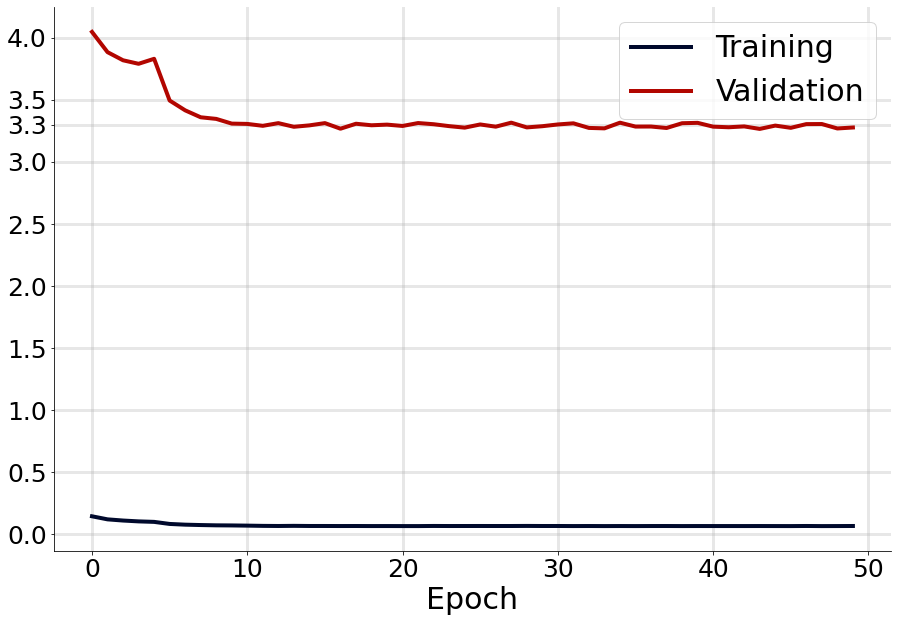

In [7]:
df_train_epoch["loss_mean"].plot(figsize=(15,10), label="Training", color="#00092C", linewidth=4, zorder=5)
df_val_epoch["loss_mean"].plot(figsize=(15,10), label="Validation", color="#B20600", linewidth=4, zorder=5)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(fontsize=30)
plt.grid(zorder=0, alpha=0.3, linewidth=3)

# plt.title("Loss Function for Experiment 01 (Backbone's Parameter is fixed)", size=20)
plt.xticks(size=25)
plt.yticks([tick for tick in np.arange(0,4.11, 0.5)]+[3.3], size=25)
plt.xlabel("Epoch", size=30)

plt.savefig(os.path.join(report_base_path, "loss_function.png"))

plt.show()

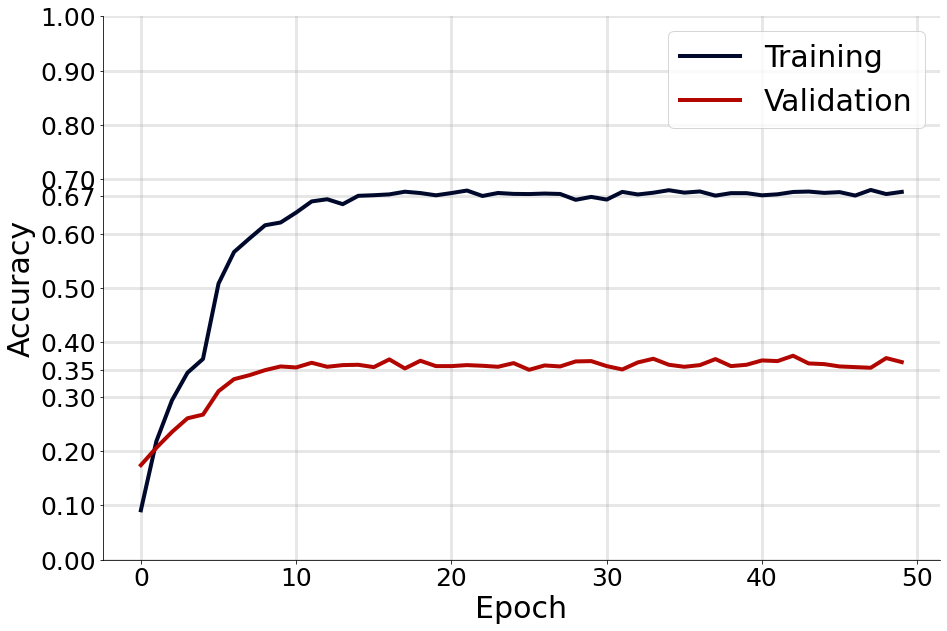

In [8]:
df_train_epoch["accuracy"].plot(figsize=(15,10), label="Training", color="#00092C", linewidth=4, zorder=5)
df_val_epoch["accuracy"].plot(figsize=(15,10), label="Validation", color="#B20600", linewidth=4, zorder=5)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(fontsize=30)
plt.grid(zorder=0, alpha=0.3, linewidth=3)

# plt.title("Accuracy for Experiment 01 (Backbone's Parameter is fixed)", size=20)
plt.xticks(size=25)
plt.yticks([ix for ix in np.arange(0,1.01, 0.1)]+[0.35,0.67],size=25)
plt.xlabel("Epoch", size=30)
plt.ylabel("Accuracy", size=30)

plt.savefig(os.path.join(report_base_path, "accuracy.png"))

plt.show()

In [9]:
df_train_lr = df_train[["epoch", "lr"]].groupby(by="epoch").mean()

df_train_lr.head(5)

,lr
epoch,
0,0.001
1,0.001
2,0.001
3,0.001
4,0.001


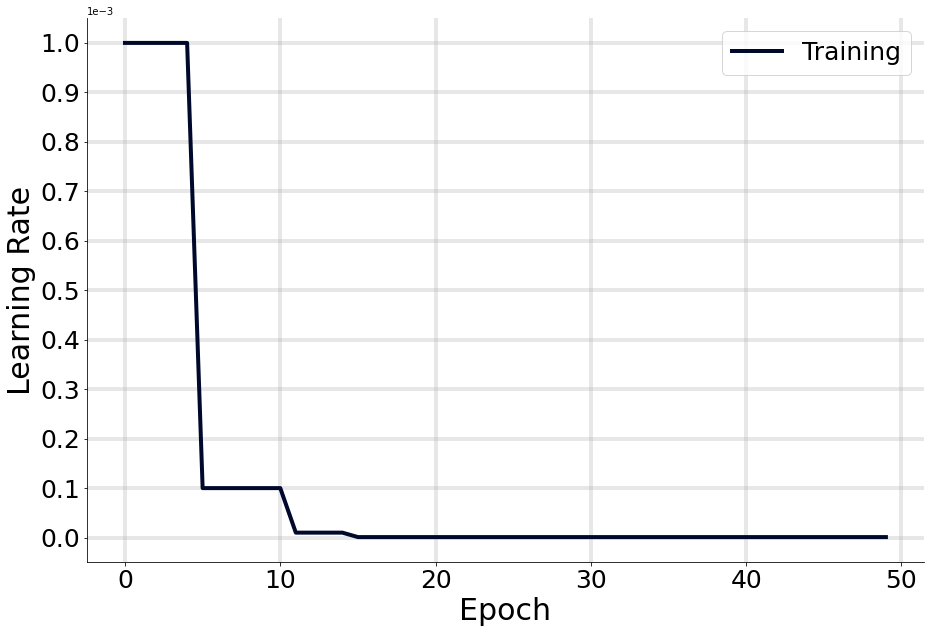

In [10]:
df_train_lr["lr"].plot(figsize=(15,10), label="Training", color="#00092C", linewidth=4, zorder=5)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(fontsize=25)
plt.grid(zorder=0, alpha=0.3, linewidth=4)

# plt.title("Learning Rate in Experiment 01 (Backbone's Parameter is fixed)", size=20)
plt.xticks(size=25)
plt.yticks([ix for ix in np.arange(0, 1.1e-3, 1e-4)],size=25)
plt.xlabel("Epoch", size=30)
plt.ylabel("Learning Rate", size=30)

ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.savefig(os.path.join(report_base_path, "learning_rate.png"))

plt.show()

## Test

In [11]:
df_test = pd.read_csv("./semi_fixed/semi_fixed_reports/test_efficientnet_b0_2022_4_8_16_41_42.csv")
df_test.drop(columns=["Unnamed: 0"], inplace=True)

df_test.head(5)

,epoch,train/eval,batch_size,loss,acc,correct,lr
0,NaN,Test,2,2.960999,NaN,1,NaN
1,NaN,Test,2,3.542440,NaN,2,NaN
2,NaN,Test,2,2.538608,NaN,2,NaN
3,NaN,Test,2,4.288519,NaN,1,NaN
4,NaN,Test,2,3.543638,NaN,2,NaN


In [12]:
num_data = df_test["batch_size"].sum()

accuracy = df_test["correct"].sum() / num_data
mean_loss = df_test["loss"].sum() / num_data

print("Accuracy: {:.2f}%".format(accuracy*100))
print("Average of Loss: {:.3f}".format(mean_loss))

Accuracy: 80.04%
Average of Loss: 1.682


## Visualization

In [13]:
ckpt_load = "./all_fixed/all_fixed_checkpoints/ckpt__final.zip"
num_categories = 196

backbone = models.efficientnet_b0(
    pretrained=False, progress=True)

net = nets.MyEfficientNetB(
    eff_net_backbone=backbone,
    num_categories=num_categories
)

net, _ = nets.load(
    ckpt_path=ckpt_load, model=net, optimizer=None)

net = net.eval()


In [14]:
def open_transform_image(path):
    mean, std = [0.471, 0.460, 0.455], [0.267, 0.266, 0.271]

    # transform val
    img_transforms = transforms.Compose([
            transforms.Resize((240, 240)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std, inplace=True)
        ])
    img = Image.open(path)
    image = img_transforms(img)
    
    return image

def interpretation_transform(path):
    img_transforms = transforms.Compose([
            transforms.Resize((240, 240)),
            transforms.ToTensor()
        ])
    img = Image.open(path)
    image = img_transforms(img)
    
    return image

def predict_label(img, model=net):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    output = F.softmax(yb, dim=1)
    prediction_score, pred = torch.topk(output, 1)

    return pred.squeeze()

In [15]:
df_test_csv = pd.read_csv("./datasets/stanford_car_196/test.csv")
df_test_csv.drop(columns=["Unnamed: 0"], inplace=True)

df_test_csv

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,file_name,gray_scale,label
0,30,52,246,147,00001.jpg,False,180
1,100,19,576,203,00002.jpg,False,102
2,51,105,968,659,00003.jpg,False,144
3,67,84,581,407,00004.jpg,False,186
4,140,151,593,339,00005.jpg,False,184
...,...,...,...,...,...,...,...
8036,49,57,1169,669,08037.jpg,False,62
8037,23,18,640,459,08038.jpg,False,15
8038,33,27,602,252,08039.jpg,False,16
8039,33,142,521,376,08040.jpg,False,37


In [16]:
# Randomly select an image
test_path = "./datasets/stanford_car_196/cars_test"
test_image_name = df_test_csv.sample()["file_name"].values[0]
test_image_name = "00003.jpg"
test_image_path = os.path.join(test_path, test_image_name)

print(f"Test Image: {test_image_path}")

# Read selected image
test_image = open_transform_image(test_image_path)
transformed_img = interpretation_transform(test_image_path)
""
# Predict label of the selected image with the model
pred_ix = predict_label(test_image)
interpretation_image = test_image.unsqueeze(0)


Test Image: ./datasets/stanford_car_196/cars_test/00003.jpg


In [17]:
integrated_gradients = IntegratedGradients(net)
attributions_ig = integrated_gradients.attribute(interpretation_image, target=pred_ix, n_steps=5)

### IntegratedGradients

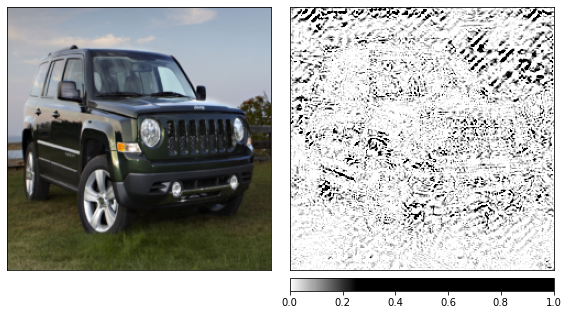

In [18]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

fig, axs = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             cmap=default_cmap,
                             show_colorbar=True,
                             signs=["all", "positive"],
                             outlier_perc=1)

fig.savefig(os.path.join(report_base_path,"integrated_gradients.png"))

### GradientShap

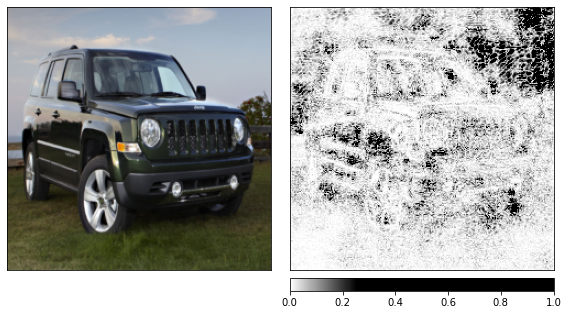

In [27]:
gradient_shap = GradientShap(net)

# Defining baseline distribution of images
rand_img_dist = torch.cat([interpretation_image * 0, interpretation_image * 1])

attributions_gs = gradient_shap.attribute(interpretation_image,
                                          baselines=rand_img_dist,
                                          target=pred_ix)

fig, axs = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

fig.savefig(os.path.join(report_base_path,"gradient_shap.png"))

### DeepLift

/Users/user/opt/anaconda3/envs/flow/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Users/user/opt/anaconda3/envs/flow/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


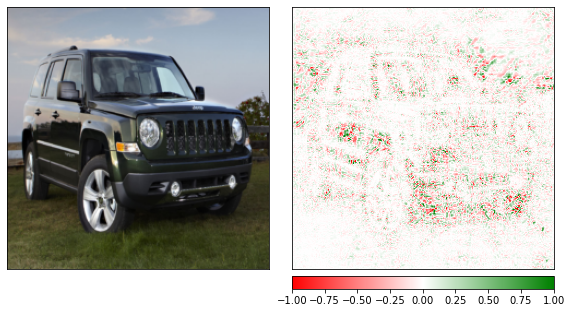

In [284]:
dl = DeepLift(net)
attributions_dl = dl.attribute(interpretation_image,
                                baselines=interpretation_image*0,
                                target=pred_ix)
fig, axs = viz.visualize_image_attr_multiple(np.transpose(attributions_dl.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "all"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

fig.savefig(os.path.join(report_base_path,"deep_lift.png"))

### Occlusion

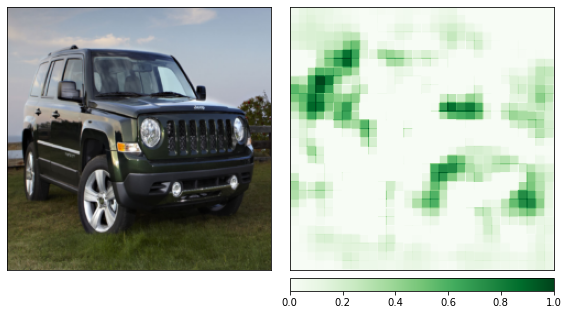

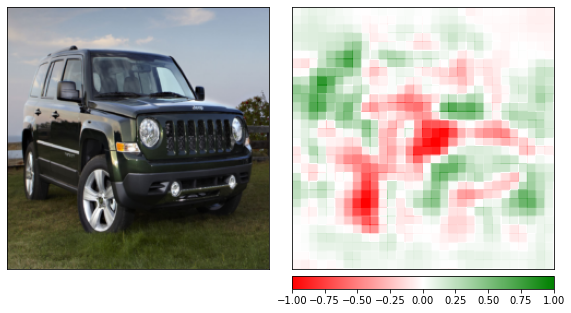

In [285]:
occlusion = Occlusion(net)

attributions_occ = occlusion.attribute(interpretation_image,
                                       strides = (3, 8, 8),
                                       target=pred_ix,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

fig1, axs1 = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )
fig2, axs2 = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "all"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

fig1.savefig(os.path.join(report_base_path,"occlusion1.png"))
fig2.savefig(os.path.join(report_base_path,"occlusion2.png"))